# How to load PDFs

[Portable Document Format (PDF)](https://en.wikipedia.org/wiki/PDF), standardized as ISO 32000, is a file format developed by Adobe in 1992 to present documents, including text formatting and images, in a manner independent of application software, hardware, and operating systems.

This guide covers how to [load](/docs/concepts/document_loaders/) `PDF` documents into the LangChain [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) format that we use downstream.

Text in PDFs is typically represented via text boxes. They may also contain images. A PDF parser might do some combination of the following:

- Agglomerate text boxes into lines, paragraphs, and other structures via heuristics or ML inference;
- Run [OCR](https://en.wikipedia.org/wiki/Optical_character_recognition) on images to detect text therein;
- Classify text as belonging to paragraphs, lists, tables, or other structures;
- Structure text into table rows and columns, or key-value pairs.
- Use multimodal LLM to extrat the body, page by page

PDF files are organized in pages. This is not a good strategy. Indeed, this approach creates memory gaps in RAG projects. If a paragraph spans two pages, the beginning of the paragraph is at the end of one page, while the rest is at the start of the next. With a page-based approach, there will be two separate chunks, each containing part of a sentence. The corresponding vectors won’t be relevant. These chunks are unlikely to be selected when there’s a question specifically about the split paragraph. If one of the chunks is selected, there’s little chance the LLM can answer the question. This issue is worsened by the injection of headers, footers (if parsers haven’t properly removed them), images, or tables at the end of a page, as most current implementations tend to do. 

Images and tables are difficult challenges for PDF parsers.

Some parsers can retrieve images. The question is what to do with them. It may be interesting to apply an OCR algorithm to extract the textual content of images, or to use a multimodal LLM to request the description of each image. With the result of an image conversion, where do I place it in the document flow? At the end? At the risk of breaking the content of a paragraph present on several pages? Implementations try to find a neutral location, between two paragraphs, if possible.

When it comes to extracting tables, some can do it, with varying degrees of success, with or without integrating the tables into the text flow. A Markdown table cannot describe combined cells, unlike an HTML table.

Finally, the metadata extracted from PDF files by the various parsers varies. We propose a minimum set that parsers should offer:

- `source`
- `page`
- `total_page`
- `creationdate`
- `creator`
- `producer`

Most parsers offer similar parameters, such as mode, which allows you to request the retrieval of one document per page (`mode="page"`), or the entire file stream in a single document (`mode="single"`). Other modes can return the structure of the document, following the identification of each component.

LangChain tries to unify the different parsers, to facilitate migration from one to the other. Why is it important? Each has its own characteristics and strategies, more or less effective depending on the family of PDF files. One strategy is to identify the family of the PDF file (by inspecting the metadata or the content of the first page) and then select the most efficient parser in that case. By unifying parsers, the following code doesn't need to deal with the specifics of different parsers, as the result is similar for each. 

LangChain integrates with a host of PDF parsers. Some are simple and relatively low-level; others will support OCR and image-processing, or perform advanced document layout analysis. The right choice will depend on your needs. Below we enumerate the possibilities.

We will demonstrate these approaches on a [sample file](https://github.com/langchain-ai/langchain/blob/master/libs/community/tests/integration_tests/examples/layout-parser-paper.pdf):

In [1]:
file_path = (
    "../../docs/integrations/document_loaders/example_data/layout-parser-paper.pdf"
)

:::info A note on multimodal models

Many modern LLMs support inference over multimodal inputs (e.g., images). In some applications -- such as question-answering over PDFs with complex layouts, diagrams, or scans -- it may be advantageous to skip the PDF parsing, instead casting a PDF page to an image and passing it to a model directly. We demonstrate an example of this in the [Use of multimodal models](/docs/how_to/document_loader_pdf/#use-of-multimodal-models) section below.

:::

## Simple and fast text extraction

If you are looking for a simple string representation of text that is embedded in a PDF, the method below is appropriate. It will return a list of [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) objects-- one per page-- containing a single string of the page's text in the Document's `page_content` attribute. It will not parse text in images, tables or scanned PDF pages. Under the hood it uses the [pypdf](https://pypdf.readthedocs.io/en/stable/) Python library.

LangChain [document loaders](/docs/concepts/document_loaders) implement `lazy_load` and its async variant, `alazy_load`, which return iterators of `Document` objects. We will use these below.

In [2]:
%pip install -qU langchain_community pypdf

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pprint import pprint

from patch_langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [4]:
pprint(pages[0].metadata)
print(pages[0].page_content)

{'author': '',
 'creationdate': '2021-06-22T01:27:10+00:00',
 'creator': 'LaTeX with hyperref',
 'keywords': '',
 'moddate': '2021-06-22T01:27:10+00:00',
 'page': 0,
 'producer': 'pdfTeX-1.40.21',
 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live '
                    '2020) kpathsea version 6.3.2',
 'source': '../../docs/integrations/document_loaders/example_data/layout-parser-paper.pdf',
 'subject': '',
 'title': '',
 'total_pages': 16,
 'trapped': '/False'}
LayoutParser: A Uniﬁed Toolkit for Deep
Learning Based Document Image Analysis
Zejiang Shen1 (  ), Ruochen Zhang2, Melissa Dell3, Benjamin Charles Germain
Lee4, Jacob Carlson3, and Weining Li5
1 Allen Institute for AI
shannons@allenai.org
2 Brown University
ruochen zhang@brown.edu
3 Harvard University
{melissadell,jacob carlson}@fas.harvard.edu
4 University of Washington
bcgl@cs.washington.edu
5 University of Waterloo
w422li@uwaterloo.ca
Abstract. Recent advances in document image analysis (DIA) have b

Note that the metadata of each document stores the corresponding page number.

### Vector search over PDFs

Once we have loaded PDFs into LangChain `Document` objects, we can index them (e.g., a RAG application) in the usual way. Below we use OpenAI embeddings, although any LangChain [embeddings](https://python.langchain.com/docs/concepts/embedding_models) model will suffice.

In [5]:
%pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [7]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [8]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

vector_store = InMemoryVectorStore.from_documents(pages, OpenAIEmbeddings())
docs = vector_store.similarity_search("What is LayoutParser?", k=2)
for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:300]}\n')

Page 0: LayoutParser: A Uniﬁed Toolkit for Deep
Learning Based Document Image Analysis
Zejiang Shen1 (  ), Ruochen Zhang2, Melissa Dell3, Benjamin Charles Germain
Lee4, Jacob Carlson3, and Weining Li5
1 Allen Institute for AI
shannons@allenai.org
2 Brown University
ruochen zhang@brown.edu
3 Harvard Universi

Page 13: 14 Z. Shen et al.
6 Conclusion
LayoutParser provides a comprehensive toolkit for deep learning-based document
image analysis. The oﬀ-the-shelf library is easy to install, and can be used to
build ﬂexible and accurate pipelines for processing documents with complicated
structures. It also supports hi



# Extract and analyse images



In [9]:
%pip install -qU rapidocr-onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [10]:
from patch_langchain_community.document_loaders.parsers.pdf import (
    convert_images_to_text_with_rapidocr,
)

loader = PyPDFLoader(
    file_path,
    mode="page",
    extract_images=True,
    images_to_text=convert_images_to_text_with_rapidocr(format="markdown"),
)
docs = loader.load()
print(docs[5].page_content)

6 Z. Shen et al.
Fig. 2: The relationship between the three types of layout data structures.
Coordinate supports three kinds of variation; TextBlock consists of the co-
ordinate information and extra features like block text, types, and reading orders;
a Layout object is a list of all possible layout elements, including other Layout
objects. They all support the same set of transformation and operation APIs for
maximum ﬂexibility.
Shown in Table 1, LayoutParser currently hosts 9 pre-trained models trained
on 5 diﬀerent datasets. Description of the training dataset is provided alongside
with the trained models such that users can quickly identify the most suitable
models for their tasks. Additionally, when such a model is not readily available,
LayoutParser also supports training customized layout models and community
sharing of the models (detailed in Section 3.5).
3.2 Layout Data Structures
A critical feature of LayoutParser is the implementation of a series of data
structures and ope

It is possible to ask a multimodal LLM to describe the image.

In [11]:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("OpenAI API key =")

In [12]:
from patch_langchain_community.document_loaders.parsers.pdf import (
    convert_images_to_description,
)
from langchain_openai import ChatOpenAI

loader = PyPDFLoader(
    file_path,
    mode="page",
    extract_images=True,
    images_to_text=convert_images_to_description(
        model=ChatOpenAI(model="gpt-4o-mini", max_tokens=1024), format="text"
    ),
)
docs = loader.load()
print(docs[5].page_content)

6 Z. Shen et al.
Fig. 2: The relationship between the three types of layout data structures.
Coordinate supports three kinds of variation; TextBlock consists of the co-
ordinate information and extra features like block text, types, and reading orders;
a Layout object is a list of all possible layout elements, including other Layout
objects. They all support the same set of transformation and operation APIs for
maximum ﬂexibility.
Shown in Table 1, LayoutParser currently hosts 9 pre-trained models trained
on 5 diﬀerent datasets. Description of the training dataset is provided alongside
with the trained models such that users can quickly identify the most suitable
models for their tasks. Additionally, when such a model is not readily available,
LayoutParser also supports training customized layout models and community
sharing of the models (detailed in Section 3.5).
3.2 Layout Data Structures
A critical feature of LayoutParser is the implementation of a series of data
structures and ope

# Extract tables

Some parsers can extract tables. This is the case of `PDFPlumberLoader`


In [13]:
%pip install -qU langchain_community pdfplumber

Note: you may need to restart the kernel to use updated packages.


In [14]:
from patch_langchain_community.document_loaders import PDFPlumberLoader

loader = PDFPlumberLoader(
    file_path,
    mode="page",
    extract_tables="markdown",
)
docs = loader.load()
print(docs[4].page_content)

LayoutParser: A Unified Toolkit for DL-Based DIA 5
Table 1: Current layout detection models in the LayoutParser model zoo
Dataset
|||
|---|---|
|BaseModel1|LargeModel|
|F/M M F F F/M|M - - F -|

Notes
PubLayNet[38] Layoutsofmodernscientificdocuments
PRImA[3] Layoutsofscannedmodernmagazinesandscientificreports
Newspaper[17] LayoutsofscannedUSnewspapersfromthe20thcentury
TableBank[18] Tableregiononmodernscientificandbusinessdocument
HJDataset[31] LayoutsofhistoryJapanesedocuments
1Foreachdataset,wetrainseveralmodelsofdifferentsizesfordifferentneeds(thetrade-offbetweenaccuracy
vs.computationalcost).For“basemodel”and“largemodel”,werefertousingtheResNet50orResNet101
backbones[13],respectively.Onecantrainmodelsofdifferentarchitectures,likeFasterR-CNN[28](F)andMask
R-CNN[12](M).Forexample,anFintheLargeModelcolumnindicatesithasaFasterR-CNNmodeltrained
usingtheResNet101backbone.Theplatformismaintainedandanumberofadditionswillbemadetothemodel
zooincomingmonths.
layout data structures, which are 

## Layout analysis and extraction of text from images

If you require a more granular segmentation of text (e.g., into distinct paragraphs, titles, tables, or other structures) or require extraction of text from images, the method below is appropriate. It will return a list of [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) objects, where each object represents a structure on the page. The Document's metadata stores the page number and other information related to the object (e.g., it might store table rows and columns in the case of a table object).

Under the hood it uses the `langchain-unstructured` library. See the [integration docs](/docs/integrations/document_loaders/unstructured_file/) for more information about using [Unstructured](https://docs.unstructured.io/welcome) with LangChain.

Unstructured supports multiple parameters for PDF parsing:
- `strategy` (e.g., `"auto"`, `"fast"`, `"ocr_only"` or `"hi-res"`)
- API or local processing. You will need an API key to use the API.

The [hi-res](https://docs.unstructured.io/api-reference/how-to/choose-hi-res-model) strategy provides support for document layout analysis and OCR. We demonstrate it below via the API. See [local parsing](/docs/how_to/document_loader_pdf/#local-parsing) section below for considerations when running locally.

In [15]:
%pip install -qU langchain-unstructured

Note: you may need to restart the kernel to use updated packages.


In [16]:
import getpass
import os

if "UNSTRUCTURED_API_KEY" not in os.environ:
    os.environ["UNSTRUCTURED_API_KEY"] = getpass.getpass("Unstructured API Key:")

As before, we initialize a loader and load documents lazily:

In [17]:
from patch_langchain_unstructured import UnstructuredLoader

loader = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
    partition_via_api=True,
    coordinates=True,
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)

INFO: HTTP Request: GET https://api.unstructuredapp.io/general/docs "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 402 Payment Required"
ERROR: Failed to partition set 1.


ServerError: {"detail":"Your free trial has ended. Please add a payment method to your account to process more requests."}

Here we recover more than 100 distinct structures over the 16 page document:

In [18]:
print(len(docs))

0


We can use the document metadata to recover content from a single page:

In [19]:
first_page_docs = [doc for doc in docs if doc.metadata.get("page_number") == 0]

for doc in first_page_docs:
    print(doc.page_content)

### Extracting tables and other structures

Each `Document` we load represents a structure, like a title, paragraph, or table.

Some structures may be of special interest for indexing or question-answering tasks. These structures may be:
1. Classified for easy identification;
2. Parsed into a more structured representation.

Below, we identify and extract a table:

<details>
<summary>Click to expand code for rendering pages</summary>

In [20]:
%pip install -qU matplotlib PyMuPDF pillow

Note: you may need to restart the kernel to use updated packages.


In [21]:
import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)
    categories = set()
    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato",
    }
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height)
            for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(
            scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
        )
        ax.add_patch(rect)

    # Make legend
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category in ["Title", "Image", "Table"]:
        if category in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[category], label=category)
            )
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()


def render_page(doc_list: list, page_number: int, print_text=True) -> None:
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            print(f"{doc.page_content}\n")

INFO: Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: Can not load face (unknown file format; error code 0x2)
INFO: generated new fontManager


</details>

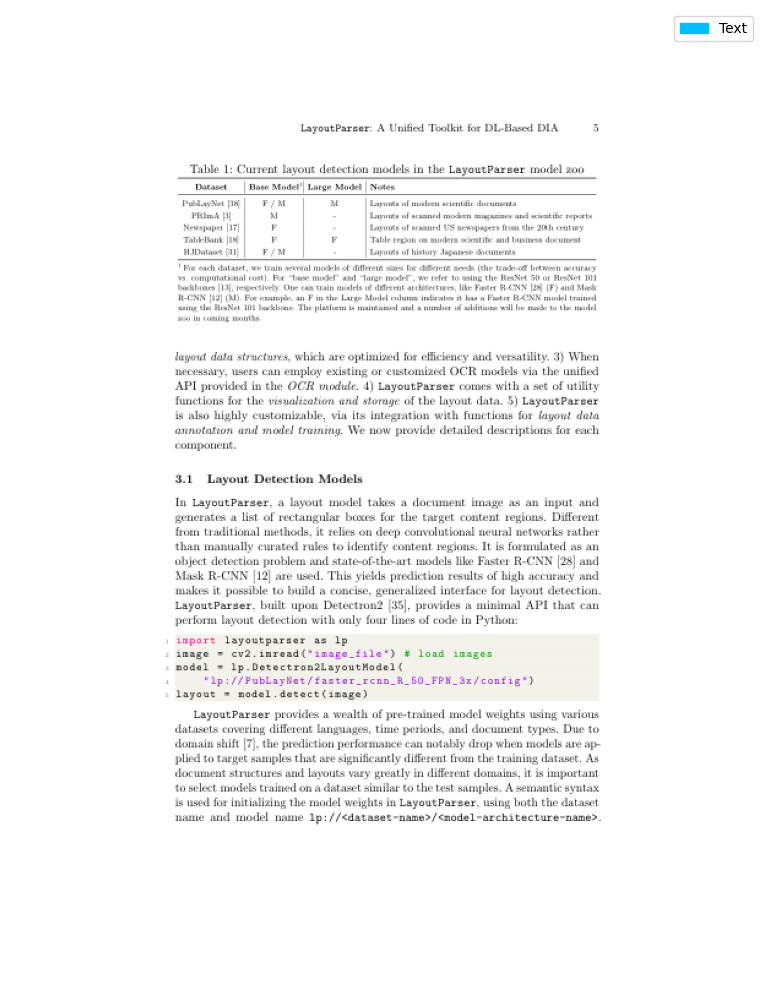

In [22]:
render_page(docs, 5)

Note that although the table text is collapsed into a single string in the document's content, the metadata contains a representation of its rows and columns:

In [23]:
from IPython.display import HTML, display

segments = [
    doc.metadata
    for doc in docs
    if doc.metadata.get("page_number") == 5 and doc.metadata.get("category") == "Table"
]

display(HTML(segments[0]["text_as_html"]))

IndexError: list index out of range

<table><thead><tr><th colspan="3">able 1. LUllclll 1ayoul actCCLloll 1110AdCs 111 L1C LayoOulralsel 1110U4cl 200</th></tr><tr><th>Dataset</th><th>| Base Model\'|</th><th>Notes</th></tr></thead><tbody><tr><td>PubLayNet [38]</td><td>F/M</td><td>Layouts of modern scientific documents</td></tr><tr><td>PRImA</td><td>M</td><td>Layouts of scanned modern magazines and scientific reports</td></tr><tr><td>Newspaper</td><td>F</td><td>Layouts of scanned US newspapers from the 20th century</td></tr><tr><td>TableBank [18]</td><td>F</td><td>Table region on modern scientific and business document</td></tr><tr><td>HJDataset</td><td>F/M</td><td>Layouts of history Japanese documents</td></tr></tbody></table>

### Extracting text from specific sections

Structures may have parent-child relationships -- for example, a paragraph might belong to a section with a title. If a section is of particular interest (e.g., for indexing) we can isolate the corresponding `Document` objects.

Below, we extract all text associated with the document's "Conclusion" section:

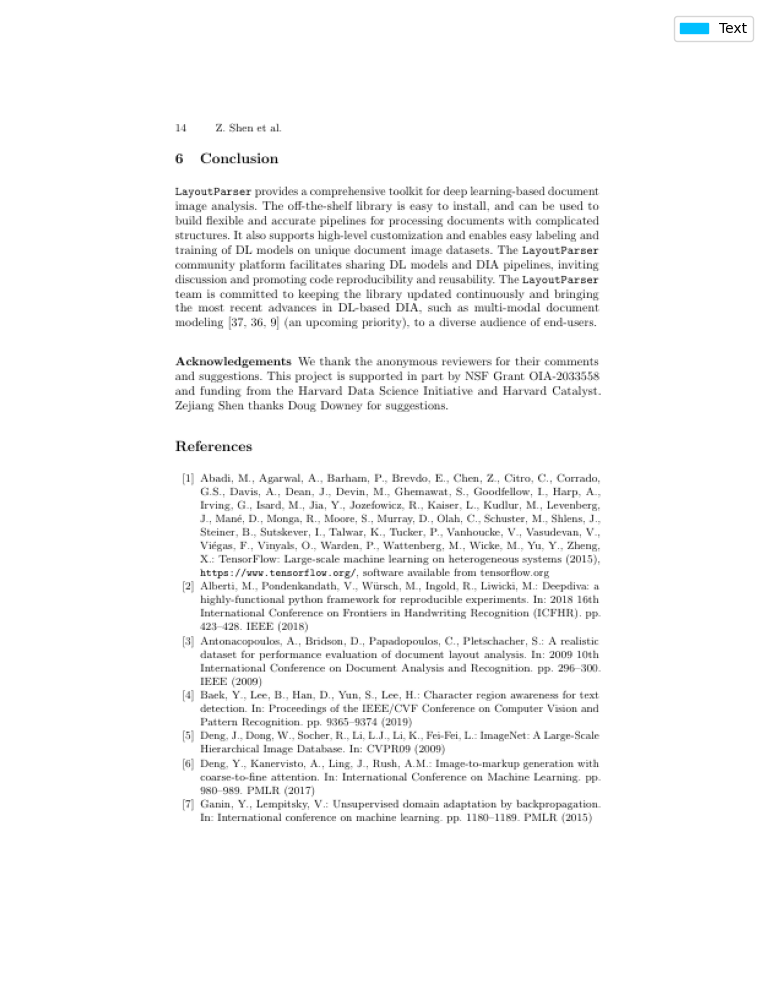

In [24]:
render_page(docs, 14, print_text=False)

In [25]:
conclusion_docs = []
parent_id = -1
for doc in docs:
    if doc.metadata["category"] == "Title" and "Conclusion" in doc.page_content:
        parent_id = doc.metadata["element_id"]
    if doc.metadata.get("parent_id") == parent_id:
        conclusion_docs.append(doc)

for doc in conclusion_docs:
    print(doc.page_content)

### Extracting text from images

OCR is run on images, enabling the extraction of text therein:

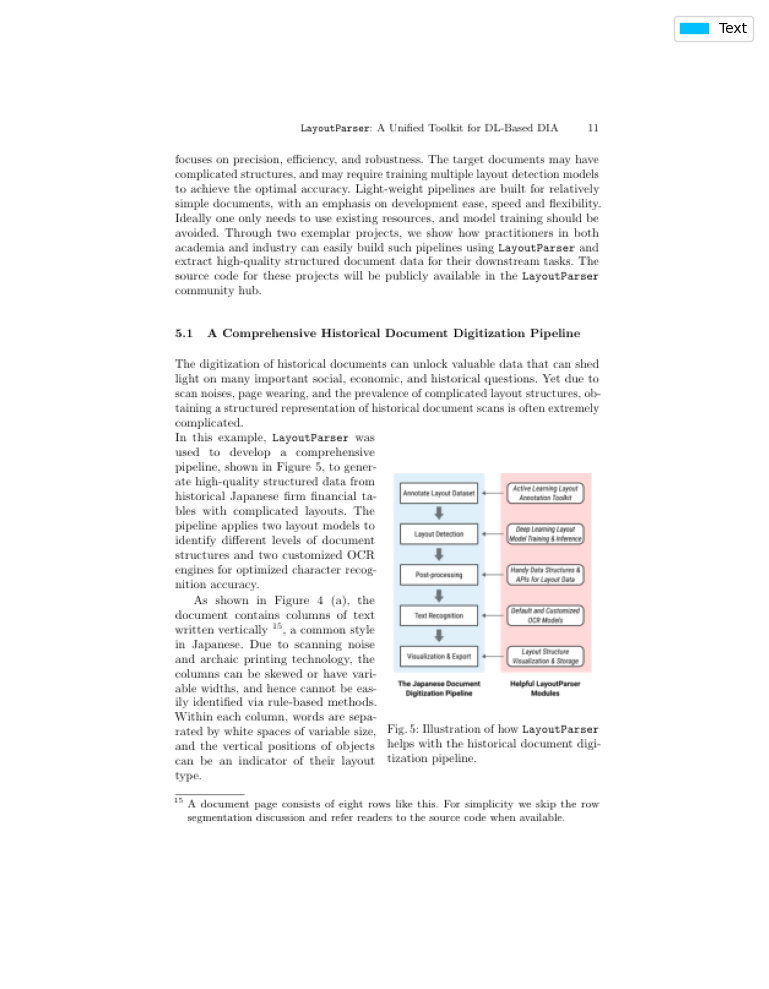

In [26]:
render_page(docs, 11)

Note that the text from the figure on the right is extracted and incorporated into the content of the `Document`.

### Local parsing

Parsing locally requires the installation of additional dependencies.

**Poppler** (PDF analysis)
- Linux: `apt-get install poppler-utils`
- Mac: `brew install poppler`
- Windows: https://github.com/oschwartz10612/poppler-windows

**Tesseract** (OCR)
- Linux: `apt-get install tesseract-ocr`
- Mac: `brew install tesseract`
- Windows: https://github.com/UB-Mannheim/tesseract/wiki#tesseract-installer-for-windows

We will also need to install the `unstructured` PDF extras:

In [27]:
%pip install -qU "unstructured[pdf]"

Note: you may need to restart the kernel to use updated packages.


We can then use the [UnstructuredLoader](https://python.langchain.com/api_reference/unstructured/document_loaders/langchain_unstructured.document_loaders.UnstructuredLoader.html) much the same way, forgoing the API key and `partition_via_api` setting:

In [29]:
loader_local = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
)
docs_local = []
for doc in loader_local.lazy_load():
    docs_local.append(doc)

INFO: Reading PDF for file: ../../docs/integrations/document_loaders/example_data/layout-parser-paper.pdf ...


The list of documents can then be processed similarly to those obtained from the API.

## Use of multimodal models

Many modern LLMs support inference over multimodal inputs (e.g., images). In some applications-- such as question-answering over PDFs with complex layouts, diagrams, or scans-- it may be advantageous to skip the PDF parsing, instead casting a PDF page to an image and passing it to a model directly. This allows a model to reason over the two dimensional content on the page, instead of a "one-dimensional" string representation.

In principle we can use any LangChain [chat model](/docs/concepts/chat_models) that supports multimodal inputs. A list of these models is documented [here](/docs/integrations/chat/). Below we use OpenAI's `gpt-4o-mini`.

First we define a short utility function to convert a PDF page to a base64-encoded image:

In [30]:
%pip install -qU PyMuPDF pillow langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [31]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

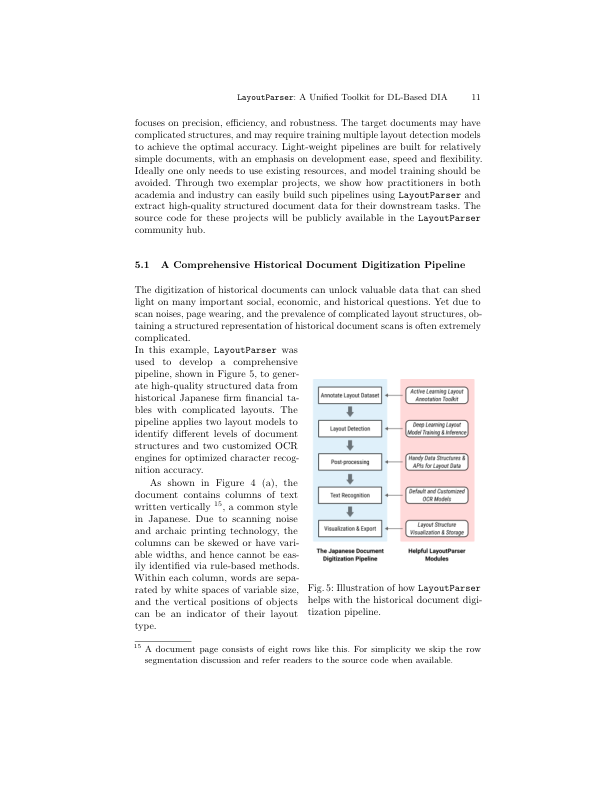

In [32]:
from IPython.display import Image as IPImage
from IPython.display import display

base64_image = pdf_page_to_base64(file_path, 11)
display(IPImage(data=base64.b64decode(base64_image)))

We can then query the model in the [usual way](/docs/how_to/multimodal_inputs/). Below we ask it a question on related to the diagram on the page.

In [33]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [34]:
from langchain_core.messages import HumanMessage

query = "What is the name of the first step in the pipeline?"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content)

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The first step in the pipeline is "Annotate Layout Dataset."


## Other PDF loaders

For a list of available LangChain PDF loaders, please see [this table](/docs/integrations/document_loaders/#pdfs).